In [1]:
import torch
import torch.nn as nn
from tqdm import tqdm

import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.utils.data as data_utils
import 

import matplotlib.pyplot as plt

# Data

In [2]:
trans = transforms.Compose([
            transforms.Resize(32),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])

train_data = dset.CIFAR10(root="../data", download=True, transform=trans)
train_loader = data_utils.DataLoader(train_data, batch_size=64, shuffle=True)

Files already downloaded and verified


# Model

In [3]:
class Generator(torch.nn.Module):
    def __init__(self, channels):
        super().__init__()
        # Filters [1024, 512, 256]
        # Input_dim = 100
        # Output_dim = C (number of channels)
        self.main_module = nn.Sequential(
            # Z latent vector 100
            nn.ConvTranspose2d(in_channels=100, out_channels=1024, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(num_features=1024),
            nn.ReLU(True),

            # State (1024x4x4)
            nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(True),

            # State (512x8x8)
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(True),

            # State (256x16x16)
            nn.ConvTranspose2d(in_channels=256, out_channels=channels, kernel_size=4, stride=2, padding=1))
            # output of main module --> Image (Cx32x32)

        self.output = nn.Tanh()

    def forward(self, x):
        x = self.main_module(x)
        return self.output(x)

In [4]:
class Discriminator(torch.nn.Module):
    def __init__(self, channels):
        super().__init__()
        # Filters [256, 512, 1024]
        # Input_dim = channels (Cx64x64)
        # Output_dim = 1
        self.main_module = nn.Sequential(
            # Image (Cx32x32)
            nn.Conv2d(in_channels=channels, out_channels=256, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            # State (256x16x16)
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            # State (512x8x8)
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True))
            # outptut of main module --> State (1024x4x4)

        self.output = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=1, kernel_size=4, stride=1, padding=0),
            # Output 1
            nn.Sigmoid())
        
    def forward(self, x):
        x = self.main_module(x)
        x = self.output(x)
        return x

In [5]:
class DCGAN():
    def __init__(self, Device = "cuda",channels = 3):
        self.device = Device
        
        self.G = Generator(channels).to(self.device)
        self.D = Discriminator(channels).to(self.device)
        self.C = channels
        
        self.loss = nn.BCELoss()
        self.d_optimizer = torch.optim.Adam(self.D.parameters(), lr=0.0002, betas=(0.5, 0.999))
        self.g_optimizer = torch.optim.Adam(self.G.parameters(), lr=0.0002, betas=(0.5, 0.999))
        
    def train(self, train_loader):
        for (images, _) in tqdm(train_loader):
            images = images.to(self.device)
            batch_size = images.shape[0]
            # Train discriminator
            # Make label tensor
            real_labels = torch.ones(batch_size).to(self.device)
            fake_labels = torch.zeros(batch_size).to(self.device)

            # Discriminator real image forward
            outputs = self.D(images)
            d_loss_real = self.loss(outputs.flatten(), real_labels)

            # Discriminator fake image forward
            z = torch.rand((batch_size, 100, 1, 1)).to(self.device)
            fake_images = self.G(z)
            outputs = self.D(fake_images)
            d_loss_fake = self.loss(outputs.flatten(), fake_labels)

            # Optimize discriminator
            d_loss = d_loss_real + d_loss_fake
            self.D.zero_grad()
            d_loss.backward()
            self.d_optimizer.step()

            # Train generator
            # Compute loss with fake images
            z = torch.rand((batch_size, 100, 1, 1)).to(self.device)
            fake_images = self.G(z)
            outputs = self.D(fake_images)
            g_loss = self.loss(outputs.flatten(), real_labels)

            # Optimize generator
            self.D.zero_grad()
            self.G.zero_grad()
            g_loss.backward()
            self.g_optimizer.step()
                
    def generate(self):
        z = torch.rand((1, 100, 1, 1)).to(self.device)
        img = self.G(z)
        img = img.reshape(self.C, 32, 32)
        img = img.permute(1, 2, 0).detach().cpu().numpy()
        return img



# Train

Epoch 1/3000


100%|██████████| 782/782 [00:39<00:00, 20.04it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


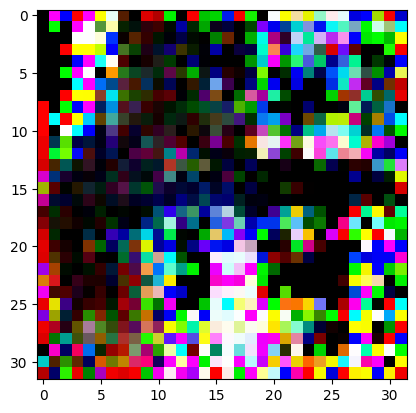

Epoch 2/3000


100%|██████████| 782/782 [00:38<00:00, 20.14it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


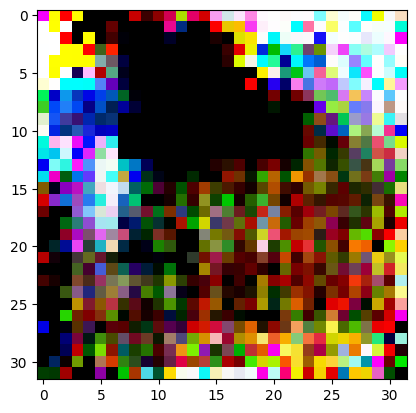

Epoch 3/3000


100%|██████████| 782/782 [00:38<00:00, 20.09it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


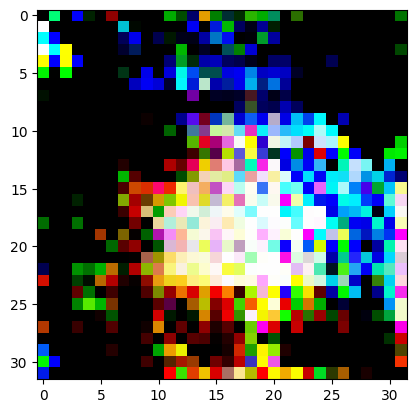

Epoch 4/3000


100%|██████████| 782/782 [00:38<00:00, 20.10it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


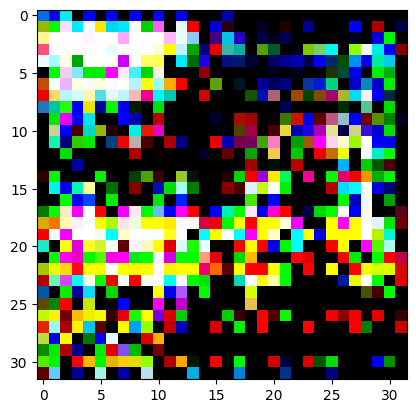

Epoch 5/3000


100%|██████████| 782/782 [00:38<00:00, 20.09it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


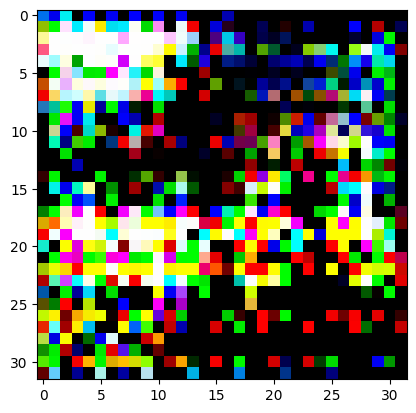

Epoch 6/3000


100%|██████████| 782/782 [00:38<00:00, 20.12it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


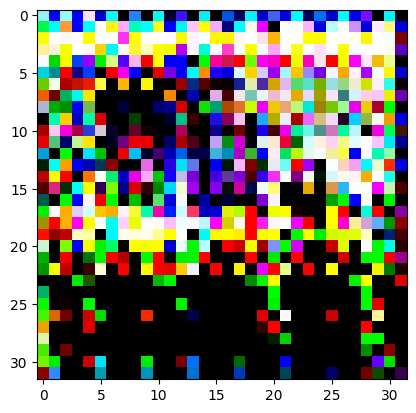

Epoch 7/3000


100%|██████████| 782/782 [00:38<00:00, 20.12it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


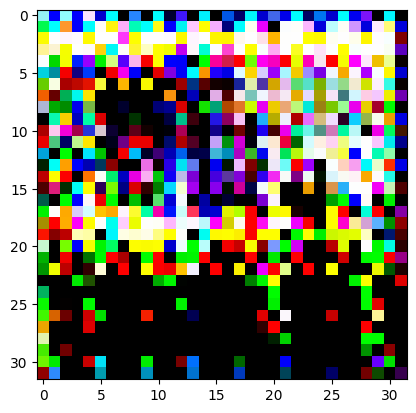

Epoch 8/3000


100%|██████████| 782/782 [00:38<00:00, 20.13it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


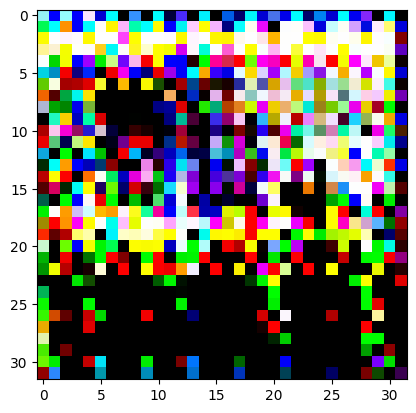

Epoch 9/3000


100%|██████████| 782/782 [00:38<00:00, 20.13it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


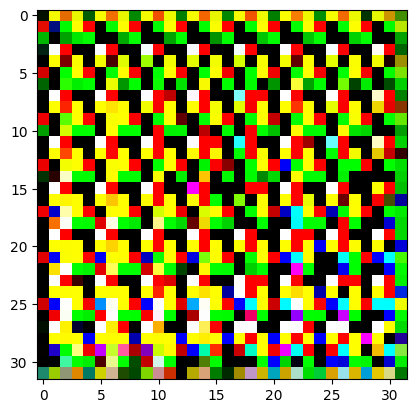

Epoch 10/3000


100%|██████████| 782/782 [00:38<00:00, 20.13it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


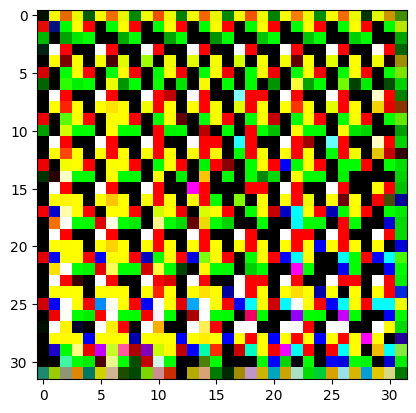

Epoch 11/3000


100%|██████████| 782/782 [00:38<00:00, 20.13it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


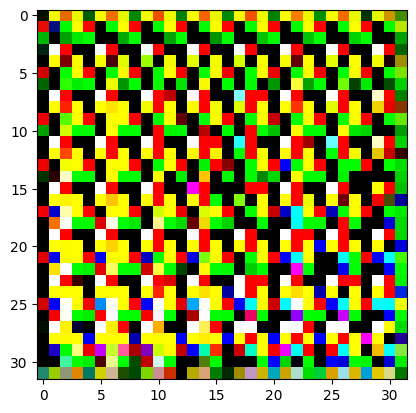

Epoch 12/3000


100%|██████████| 782/782 [00:38<00:00, 20.13it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


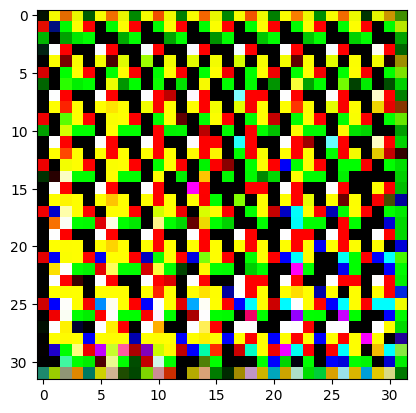

Epoch 13/3000


100%|██████████| 782/782 [00:38<00:00, 20.13it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


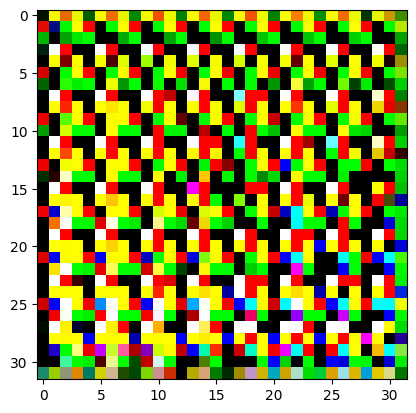

Epoch 14/3000


100%|██████████| 782/782 [00:38<00:00, 20.12it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


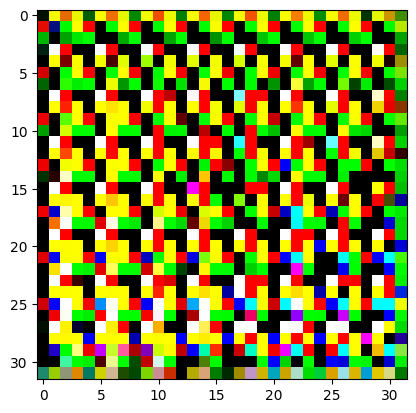

Epoch 15/3000


100%|██████████| 782/782 [00:38<00:00, 20.13it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


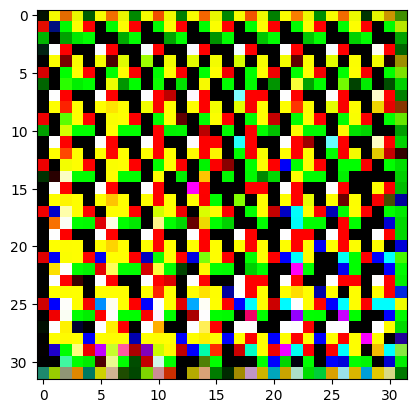

Epoch 16/3000


100%|██████████| 782/782 [00:38<00:00, 20.13it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


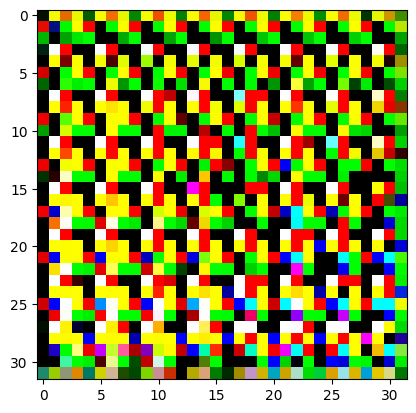

Epoch 17/3000


100%|██████████| 782/782 [00:38<00:00, 20.12it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


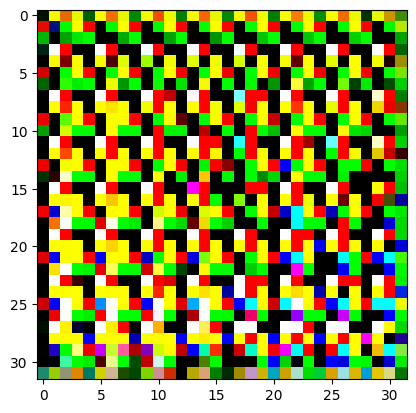

Epoch 18/3000


100%|██████████| 782/782 [00:38<00:00, 20.13it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


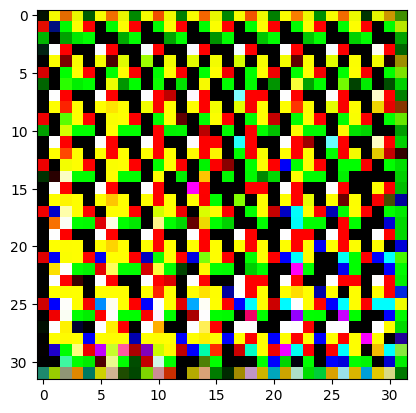

Epoch 19/3000


100%|██████████| 782/782 [00:38<00:00, 20.13it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


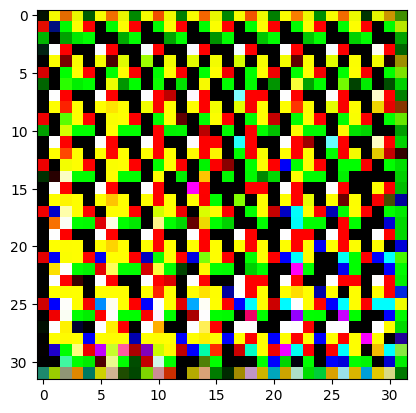

Epoch 20/3000


100%|██████████| 782/782 [00:38<00:00, 20.12it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


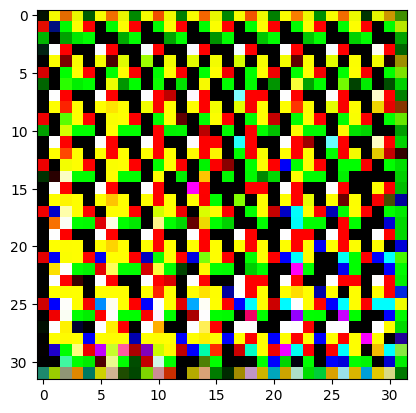

Epoch 21/3000


100%|██████████| 782/782 [00:38<00:00, 20.12it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


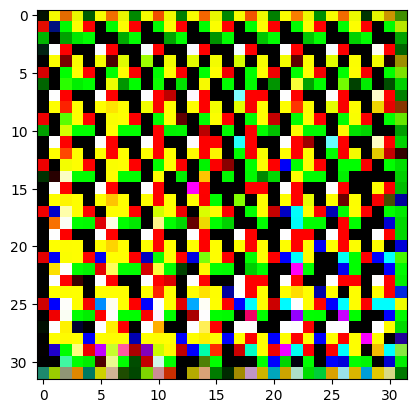

Epoch 22/3000


100%|██████████| 782/782 [00:38<00:00, 20.13it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


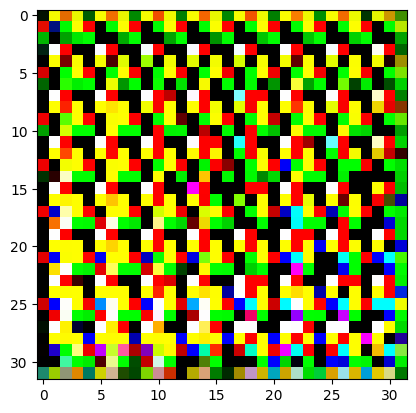

Epoch 23/3000


100%|██████████| 782/782 [00:38<00:00, 20.13it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


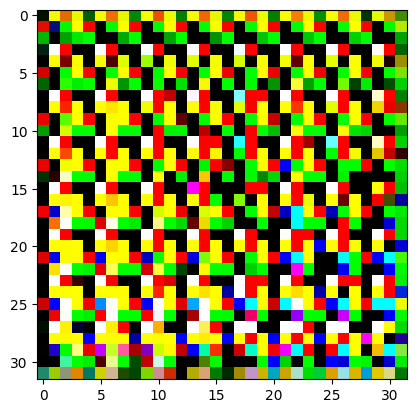

Epoch 24/3000


100%|██████████| 782/782 [00:38<00:00, 20.13it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


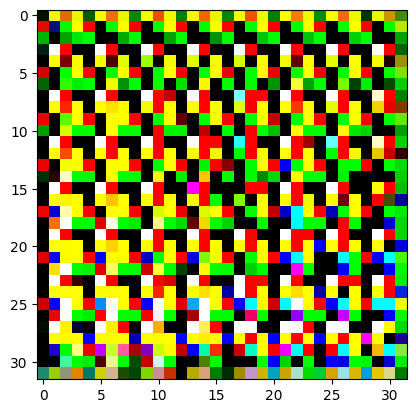

Epoch 25/3000


100%|██████████| 782/782 [00:38<00:00, 20.12it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


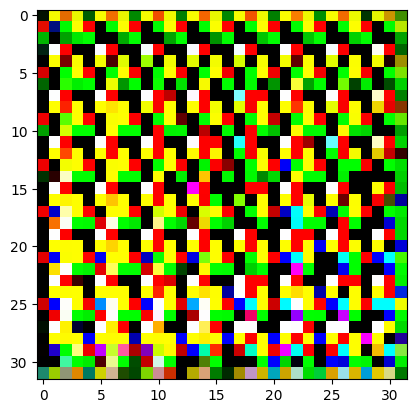

Epoch 26/3000


 48%|████▊     | 374/782 [00:18<00:20, 20.12it/s]

In [6]:
EPOCH = 3000

model = DCGAN(Device='cuda:1')
for i in range(EPOCH):
    print(f"Epoch {i + 1}/{EPOCH}")
    model.train(train_loader)
    img = model.generate()
    plt.imshow(img)
    plt.show()
    

